In [45]:
import baccoemu
import chainconsumer
import emcee
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import warnings

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plot_utils
import plotter
import utils
import run_inference as rinf
import moment_network as mn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Results

In [4]:
plot_dir = '../plots/plots_2024-03-15'
save_plots = True

data_mode = 'emuPk'
tag_data = '_2param'
tag_errG = f'_boxsize500'
tag_inf = '_'+data_mode + tag_data + tag_errG
dir_mn = f'../data/results_moment_network/mn{tag_inf}'


In [5]:
if data_mode == 'emuPk':
    frac_train=0.4
    frac_val=0.1
    frac_test=0.5
    
elif data_mode == 'muchisimocks':
    frac_train=0.70
    frac_val=0.15
    frac_test=0.15

In [6]:
dir_data = '../data/emuPks'
rng = np.random.default_rng(42)

n_tot = 2000
theta, y, y_err, k, param_names = rinf.load_data_emuPk(dir_data, tag_data, tag_errG, rng=rng)
if n_tot < theta.shape[0]:
    theta, y, y_err = rinf.subsample_data(theta, y, y_err, n_tot, rng=rng)
n_tot, n_params = theta.shape

random_ints = np.arange(n_tot)
rng.shuffle(random_ints) #in-place

idxs_train, idxs_val, idxs_test = utils.idxs_train_val_test(random_ints, 
                                frac_train=frac_train, frac_val=frac_val, frac_test=frac_test)

theta_train, theta_val, theta_test = utils.split_train_val_test(theta, idxs_train, idxs_val, idxs_test)
y_train, y_val, y_test = utils.split_train_val_test(y, idxs_train, idxs_val, idxs_test)
y_err_train, y_err_val, y_err_test = utils.split_train_val_test(y_err, idxs_train, idxs_val, idxs_test)

(10000, 2) (10000, 30) (30,) (10000, 30)
0.4 0.1 0.5


In [7]:
param_labels = [utils.param_label_dict[param_name] for param_name in param_names]

In [8]:
theta_test_pred = np.load(f'{dir_mn}/theta_test_pred.npy')
covs_test_pred = np.load(f'{dir_mn}/covs_test_pred.npy')
print(theta_test_pred.shape, covs_test_pred.shape)

(1000, 2) (1000, 2, 2)


In [9]:
# moment_network = mn.MomentNetwork(tag_mn=tag_inf)
# moment_network.load_model_mean()
history_mean = np.load(f'{dir_mn}/model_mean_history.npy', allow_pickle=True).item()
history_cov = np.load(f'{dir_mn}/model_cov_history.npy', allow_pickle=True).item()

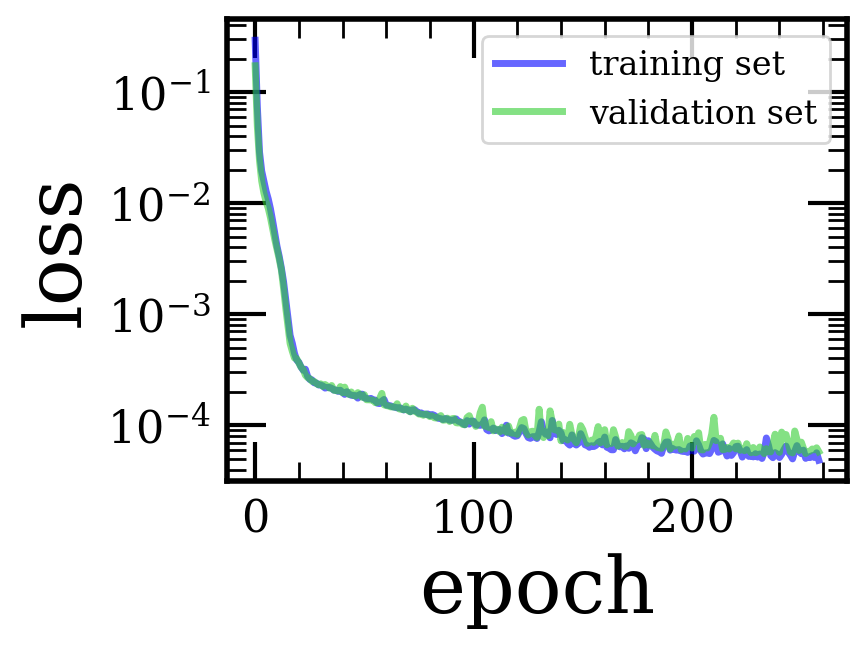

In [10]:
plotter.plot_loss(history_mean)

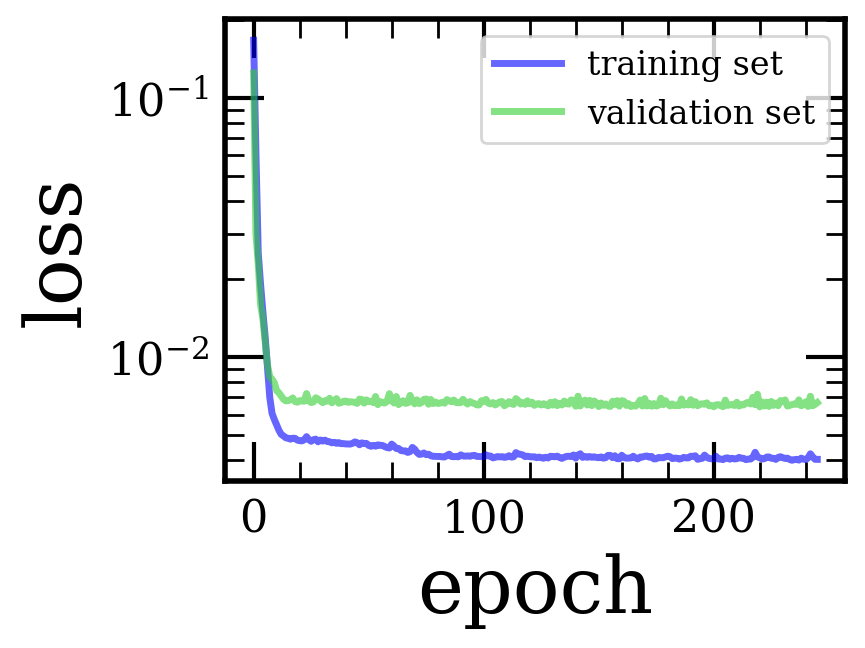

In [11]:
plotter.plot_loss(history_cov)

(1000, 2)
(1, 1000, 2)


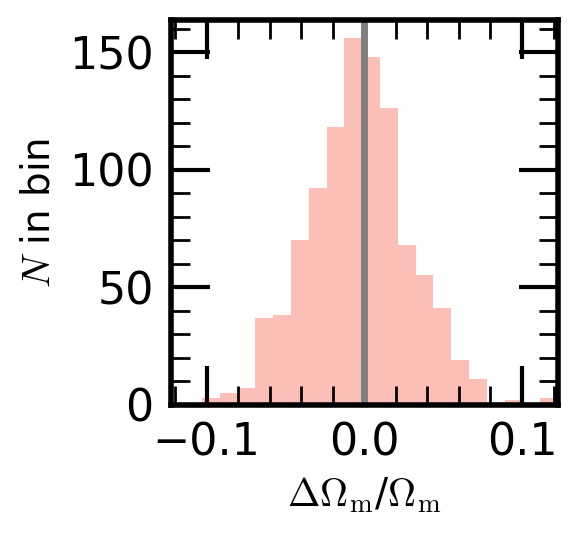

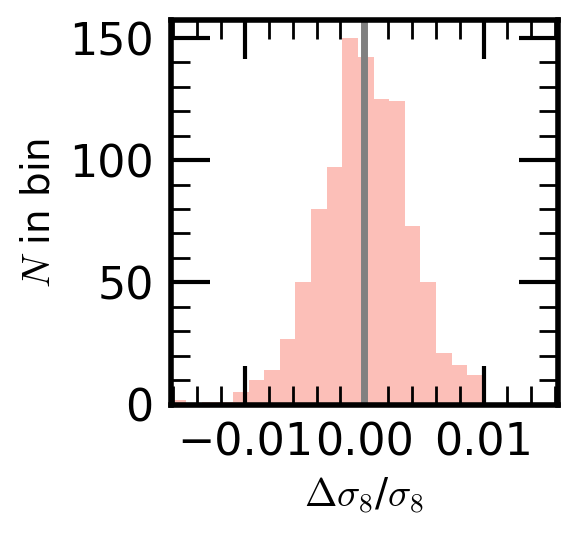

In [62]:
fracdiffs = (theta_test_pred - theta_test)/theta_test
plotter.plot_hists_mean(fracdiffs, param_labels)


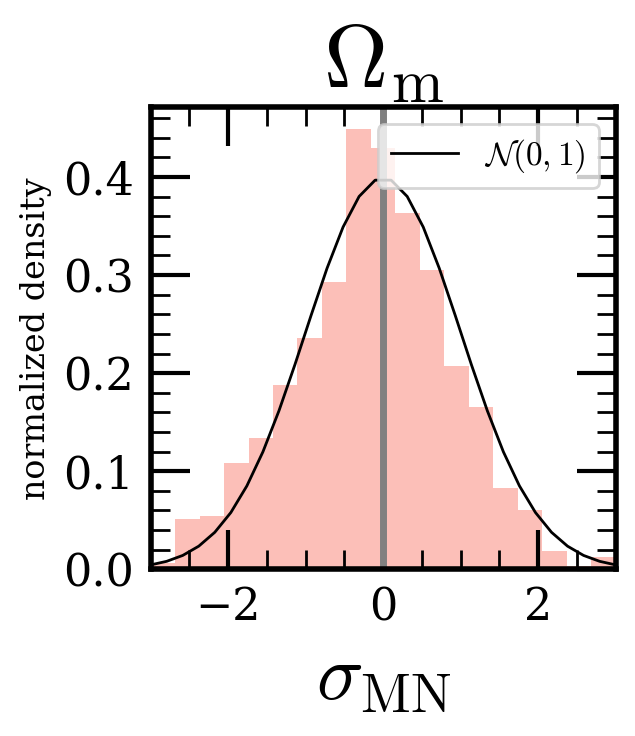

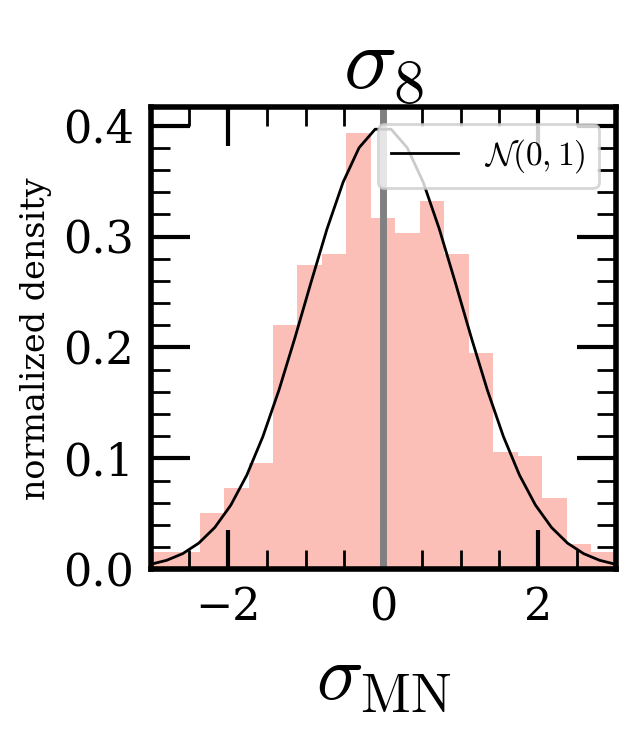

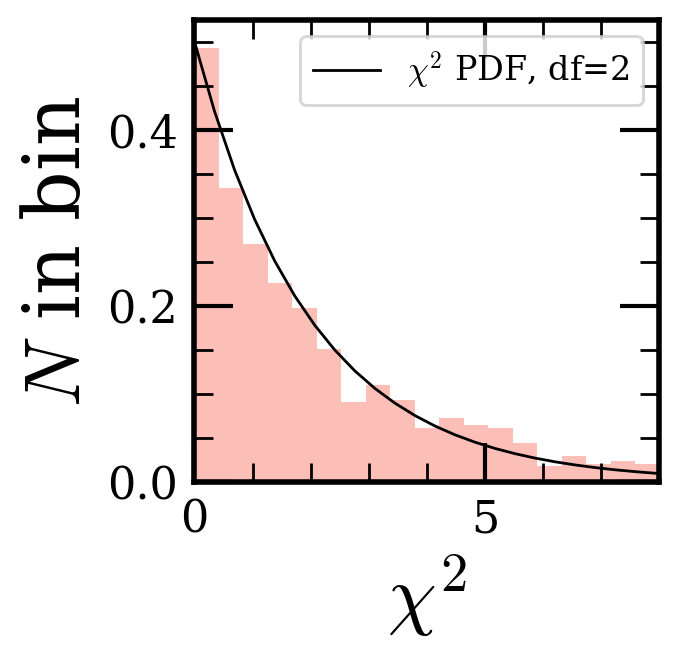

In [13]:
plotter.plot_hists_cov(theta_test, theta_test_pred, covs_test_pred, param_labels)

### Particular test sample

In [14]:
idx_test = 130

In [54]:
smooth_dict = {'mn': 1, 'emcee': 2}
bins_dict = {'mn': None, 'emcee': 10}

def plot_results(idx_test, methods):
    print(idx_test)
    title = f'test model {idx_test}'
    truth_loc = dict(zip(param_names, theta_test[idx_test]))

    samples_arr = []
    if 'mn' in methods:
        try:
            samples_mn = rng.multivariate_normal(theta_test_pred[idx_test], 
                                                 covs_test_pred[idx_test], int(1e6),
                                                 check_valid='raise')
        except ValueError:
            title += f' [$C$ not PSD!]'
            samples_mn = rng.multivariate_normal(theta_test_pred[idx_test], 
                                                 covs_test_pred[idx_test], int(1e6),
                                                 check_valid='ignore')
        samples_arr.append(samples_mn)
        
    if 'emcee' in methods:
        dir_emcee =  f'../data/results_emcee/samplers{tag_inf}'
        fn_emcee = f'{dir_emcee}/sampler_idxtest{idx_test}.npy'
        if not os.path.exists(fn_emcee):
            print(f'File {fn_emcee} not found')
            return
        reader = emcee.backends.HDFBackend(fn_emcee)

        tau = reader.get_autocorr_time()
        n_burn = int(2 * np.max(tau))
        thin = int(0.5 * np.min(tau))
        #print(n_burn, thin)
        samples_emcee = reader.get_chain(discard=n_burn, flat=True, thin=thin)
        samples_arr.append(samples_emcee)

    smooth_arr = [smooth_dict[method] for method in methods]
    bins_arr = [bins_dict[method] for method in methods]
    colors = [utils.color_dict_methods[meth] for meth in methods]
    labels = [utils.label_dict_methods[meth] for meth in methods]

    plotter.plot_contours(samples_arr, labels, colors, param_names, utils.param_label_dict, 
                        smooth_arr=smooth_arr, bins_arr=bins_arr,
                        truth_loc=truth_loc, title=title, extents={}, fn_save=None)


0
False
im in except! 0
File ../data/results_emcee/samplers_emuPk_2param_boxsize500/sampler_idxtest0.npy not found
1
True
finished try! 1
File ../data/results_emcee/samplers_emuPk_2param_boxsize500/sampler_idxtest1.npy not found
2
True
finished try! 2
3
True
finished try! 3
File ../data/results_emcee/samplers_emuPk_2param_boxsize500/sampler_idxtest3.npy not found
4
True
finished try! 4
File ../data/results_emcee/samplers_emuPk_2param_boxsize500/sampler_idxtest4.npy not found
5
False
im in except! 5
File ../data/results_emcee/samplers_emuPk_2param_boxsize500/sampler_idxtest5.npy not found
6
True
finished try! 6
7
True
finished try! 7
8
True
finished try! 8
9
True
finished try! 9
10
False
im in except! 10
11
False
im in except! 11
File ../data/results_emcee/samplers_emuPk_2param_boxsize500/sampler_idxtest11.npy not found
12
True
finished try! 12
13
True
finished try! 13
File ../data/results_emcee/samplers_emuPk_2param_boxsize500/sampler_idxtest13.npy not found
14
True
finished try! 14
Fi

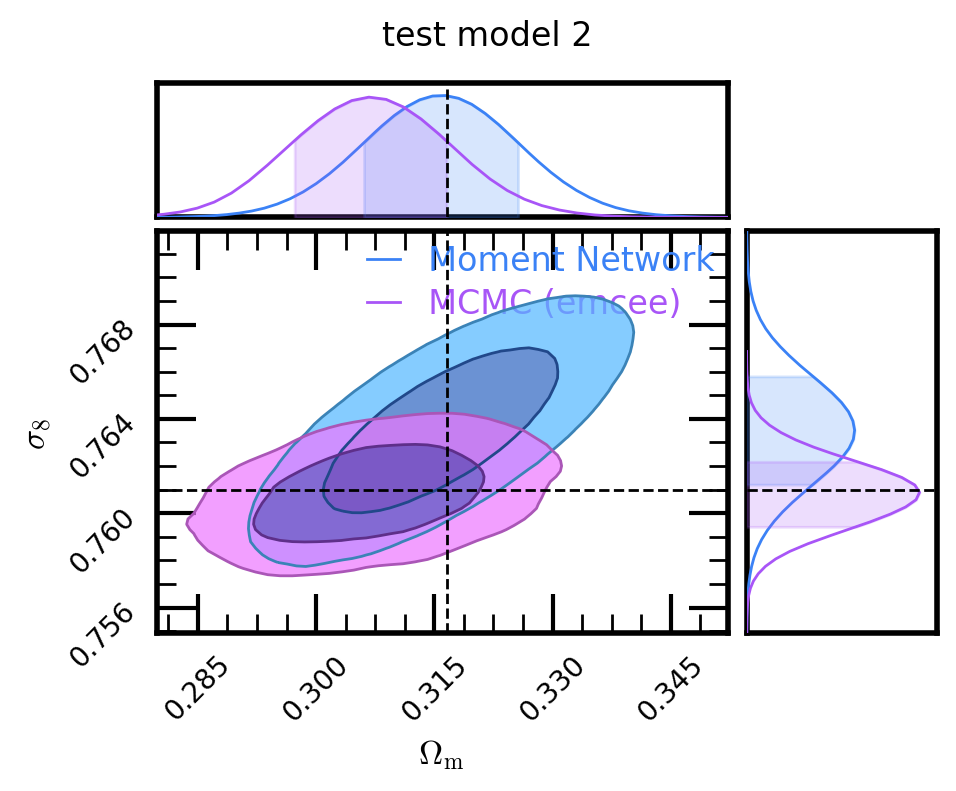

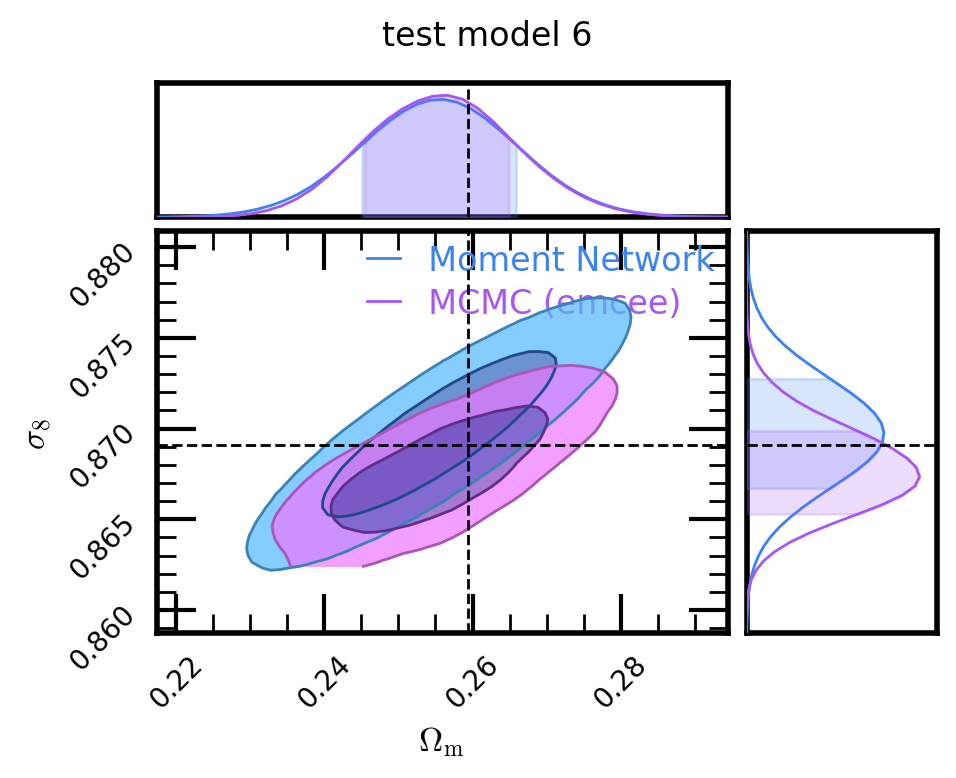

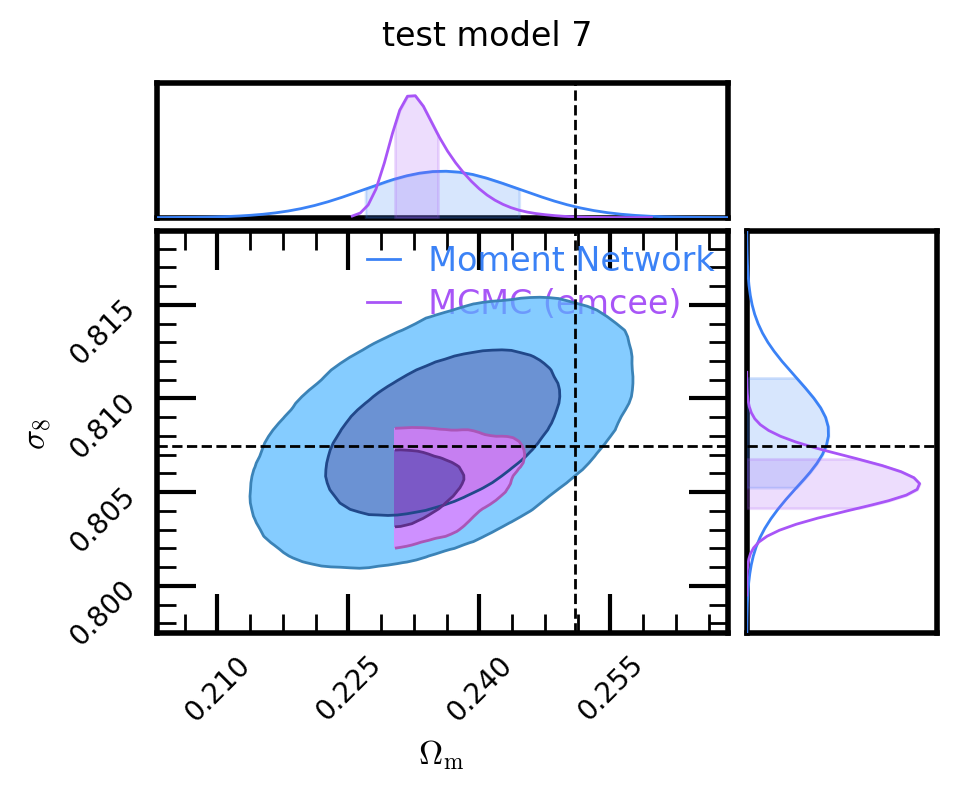

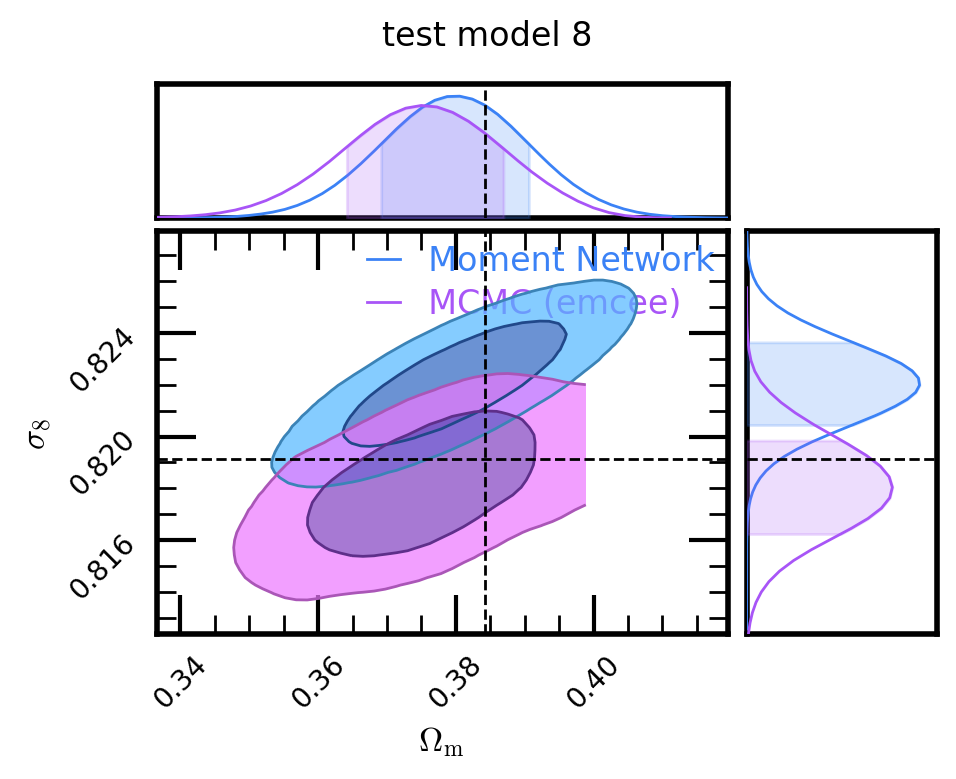

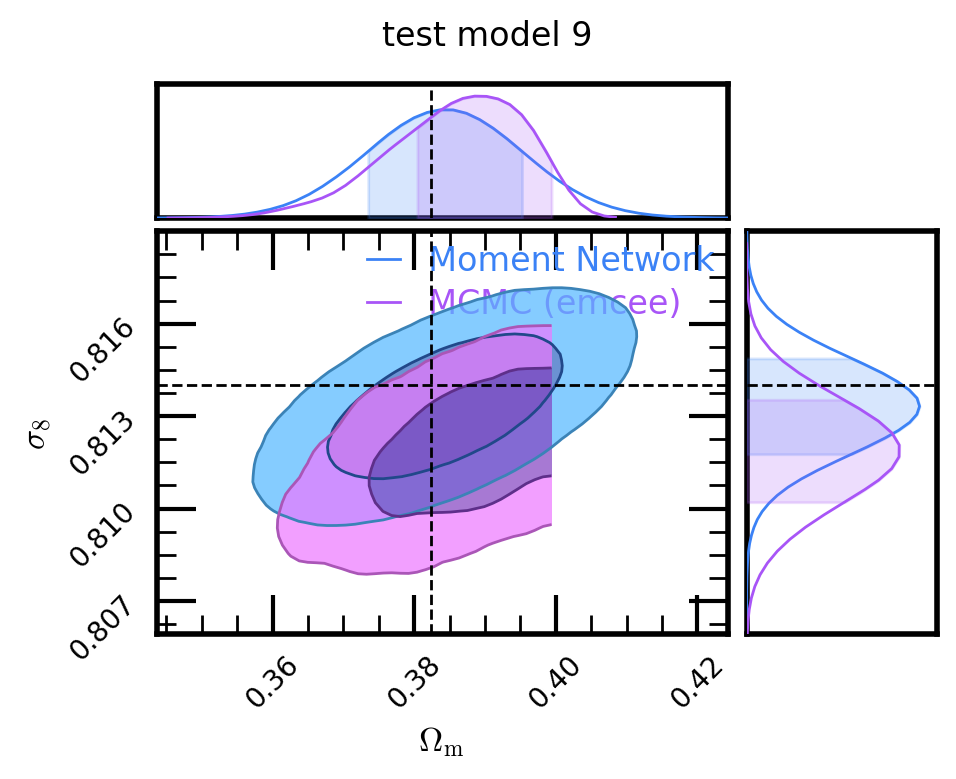

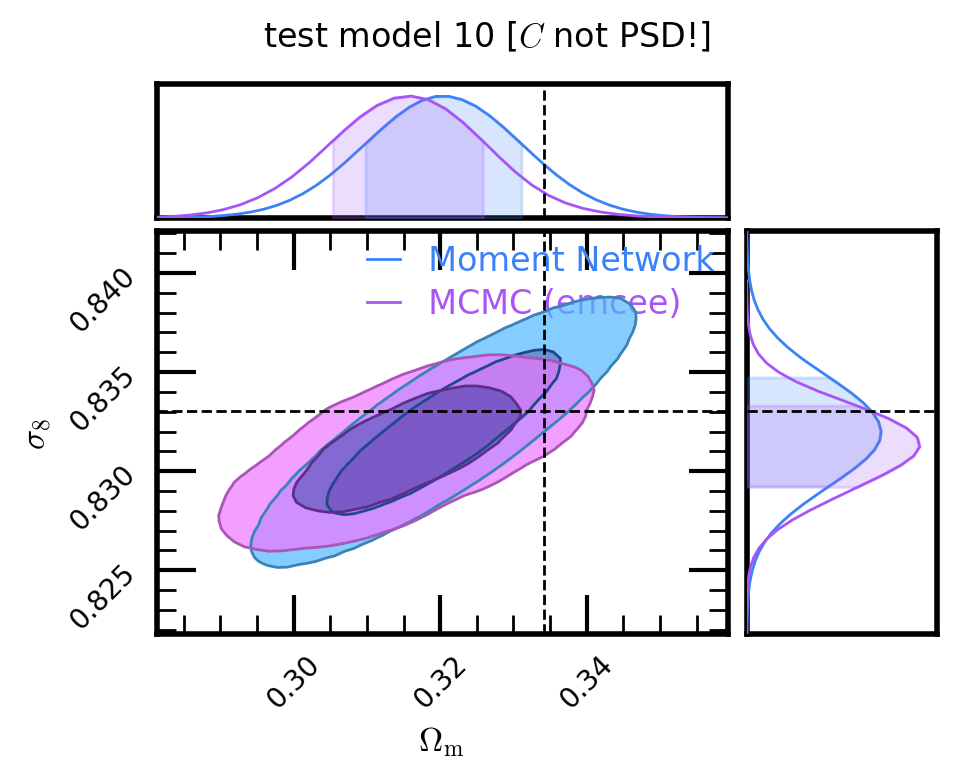

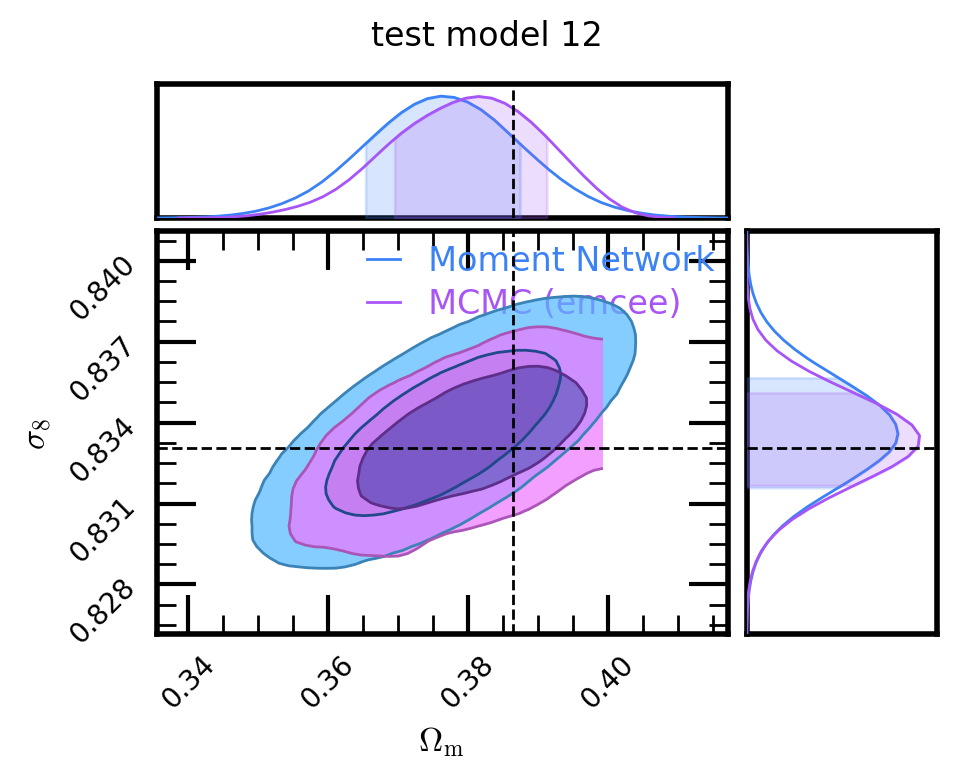

In [55]:
methods = ['mn', 'emcee']
idxs_test = np.arange(15)
#idxs_test = [6]
for idx_test in idxs_test:
    plot_results(idx_test, methods)


### Compare emcee to moment

In [65]:
import re
dir_emcee =  f'../data/results_emcee/samplers{tag_inf}'
idxs_testsub = []
pattern = r'idxtest(\d+)'
for fn in os.listdir(dir_emcee):
    if fn.startswith("sampler_idxtest"):
        match = re.search(pattern, fn)
        idxs_testsub.append(int(match.group(1)))

In [71]:
idxs_testsub.remove(100)

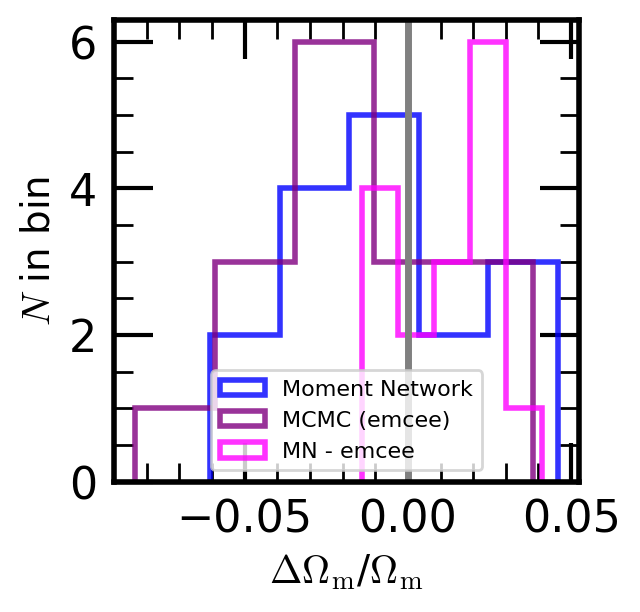

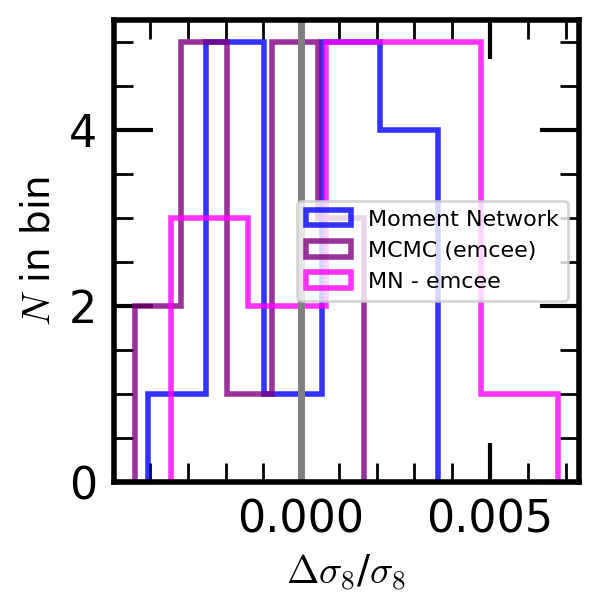

In [88]:
theta_testsub = theta_test[idxs_testsub]
theta_testsub_pred_mn = theta_test_pred[idxs_testsub]
theta_testsub_pred_emcee = []
for idx_testsub in idxs_testsub:
    fn_emcee = f'{dir_emcee}/sampler_idxtest{idx_testsub}.npy'
    if not os.path.exists(fn_emcee):
        print(f'File {fn_emcee} not found')
        continue
    reader = emcee.backends.HDFBackend(fn_emcee)

    tau = reader.get_autocorr_time()
    n_burn = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    #print(n_burn, thin)
    samples_emcee = reader.get_chain(discard=n_burn, flat=True, thin=thin)
    log_prob_samples = reader.get_log_prob(discard=n_burn, flat=True, thin=thin)
    idx_max_log_prob = np.argmax(log_prob_samples)
    theta_testsub_pred_emcee.append(samples_emcee[idx_max_log_prob])

fracdiffs_mn_emcee = (theta_testsub_pred_mn - theta_testsub_pred_emcee)/theta_testsub_pred_emcee
fracdiffs_mn = (theta_testsub_pred_mn - theta_testsub)/theta_testsub
fracdiffs_emcee = (theta_testsub_pred_emcee - theta_testsub)/theta_testsub
fracdiffs_arr = np.array([fracdiffs_mn, fracdiffs_emcee, fracdiffs_mn_emcee])
color_arr = [utils.color_dict_methods['mn'], utils.color_dict_methods['emcee'], 'magenta']
label_arr = [utils.label_dict_methods['mn'], utils.label_dict_methods['emcee'], 'MN - emcee']
plotter.plot_hists_mean(fracdiffs_arr, param_labels, 
                        color_arr=color_arr, label_arr=label_arr,
                        bins=5, alpha=0.8, histtype='step')
